In [148]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
import numpy.ma as ma
import cartopy.crs as ccrs

#import mplotutils as mpu
#import cf_units
from tqdm import tqdm_notebook as tqdm

import glob



In [149]:
## functions to calculate trends, 

def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(36),np.arange(72))
    slope=np.full([36,72],np.nan)
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        if not np.all(np.isnan(df[i_start:i_end+1,i_x,i_y])):
            #print(np.all(df[i_start:i_end+1,i_x,i_y]==np.nan),df[i_start:i_end+1,i_x,i_y])
            slope[i_x,i_y]=100*stats.linregress(np.arange(end-start+1)[~np.isnan(df[i_start:i_end+1,i_x,i_y])],
                                                df[i_start:i_end+1,i_x,i_y][~np.isnan(df[i_start:i_end+1,i_x,i_y])])[0]
    return slope

def mean_trend_from_dict(df,df_time,start,end, roll=False):
    
    print([df[key].shape for key in df.keys()])
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.mean(all_trends,axis=0),36,1)
    else:
        return np.mean(all_trends,axis=0)
    
def trend_dist_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.quantile(all_trends,[0.05,0.95],axis=0),36,1)
    else:
        return np.quantile(all_trends,[0.05,0.95],axis=0)
    
def trend_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(all_trends,36,1)
    else:
        return all_trends
        
            
def create_mask(df):
    
    ##First check that the year is 'valid' i.e. 5 months are non nana
    df=df.reshape(-1,12,df.shape[1],df.shape[2])
    valid_idx=np.zeros([df.shape[0],36,72])
    
    for yr_idx in range(df.shape[0]):
        valid_idx[yr_idx,:,:]=np.where(np.isnan(df[yr_idx,:,:,:]).sum(axis=0)>6,1,0)
        

    cutoff=valid_idx.shape[0]%5
            
    valid_idx=valid_idx[cutoff:,:,:].reshape(5,-1,36,72)
    
    mask_idx=np.zeros([5,36,72])
    
    for idx_block in range(5):
        mask_idx[idx_block,:,:]=np.where(valid_idx[idx_block,:,:,:].sum(axis=0)>np.floor(0.2*valid_idx.shape[1]),
                                                np.nan,1)
        
    print(valid_idx.shape,np.floor(0.8*valid_idx.shape[1]))
    mask_idx=np.prod(mask_idx,axis=0)
    
    return np.roll(~np.isnan(mask_idx),36,1)

In [150]:
# read in observations
hadcrut_anom={}

dir_var_hn='data/HadCRUT_observations/'
obs_name_list=sorted(glob.glob(dir_var_hn+'HadCRUT.4.6.0.0.anomalies.*.nc'))

for i,obs_name in enumerate(obs_name_list): 
    data=xr.open_mfdataset(obs_name).groupby('time.year').mean('time').roll(longitude=180, roll_coords=True).sel(year=slice('1869-01-01', '2101-01-01'))
    hadcrut_anom[i]=data.temperature_anomaly.values

# reference year to calculate trend    
ref=1951

hadcrut_med=xr.open_mfdataset('data/HadCRUT.4.6.0.0.median.nc')
hadcrut_med=hadcrut_med.groupby('time.year').mean('time')#.sel(time=slice('1870-01-01', '2101-01-01'))

trend_hadcrut_med={}
trend_hadcrut={}

# trends for all years in temperature
for year_idx in range(2000,2019):
 
    trend_hadcrut_med[year_idx]=linregress_grid(hadcrut_med.sel(year=slice(1870,2021)).roll(longitude=180, roll_coords=True).temperature_anomaly.values,
                         hadcrut_med.sel(year=slice(1870,2021)).year.values,ref,year_idx)
    trend_hadcrut[year_idx]=trend_dist_from_dict(hadcrut_anom,np.arange(1870,2021),ref,year_idx)

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/sarah/projects/climate_change_impact/climate/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/tmp/ipykernel_1518658/917643053.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])


  0%|          | 0/100 [00:00<?, ?it/s]

In [151]:
# match [temperature, years] to 5 degree grid, save as file
degrees = 5
lons = np.linspace(degrees*.5,360-degrees*.5,int(360/degrees))
lats = np.linspace(-90+degrees*.5,90-degrees*.5,int(180/degrees))
xv, yv = np.meshgrid(lons,lats)

temp = list()
years = list()
lon = list()
lat = list()

for year in range(2000,2019):
    temps = trend_hadcrut_med[year].flatten()
    temp.extend(temps)
    years.extend([year for i in range(len(temps))])
    lon.extend(list(xv.flatten()))
    lat.extend(list(yv.flatten()))
    
    
year_temp_grid = pd.DataFrame({"year": years, "temperature": temp, "LON_5":lon,"LAT_5":lat})
year_temp_grid.to_csv("data/grid5_temp_years.csv")

In [152]:
# match fine subgrid with GDL code on coarse temperature-trend data
grid_region = pd.read_csv('data/subgrid.csv')
grid_region = grid_region[['LAT_5','LON_5','GDLcode', 'area']]
year_temp_grid = year_temp_grid.merge(grid_region, on=["LAT_5", "LON_5"])
year_temp_grid["weighted_area"] = year_temp_grid.area/max(year_temp_grid.area)
year_temp_grid["weighted_temp"] = year_temp_grid["temperature"]*year_temp_grid["weighted_area"]
year_temp_grid.groupby(["GDLcode","year"]).mean("weighted_temp").reset_index().to_csv("data/region_temp_years.csv")

/tmp/ipykernel_1518658/2923671239.py:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  grid_region = pd.read_csv('data/subgrid.csv')


## Some plots

(5, 13, 36, 72) 10.0


/tmp/ipykernel_1518658/1892971264.py:60: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)


(0.0, 1.0, 0.0, 1.0)

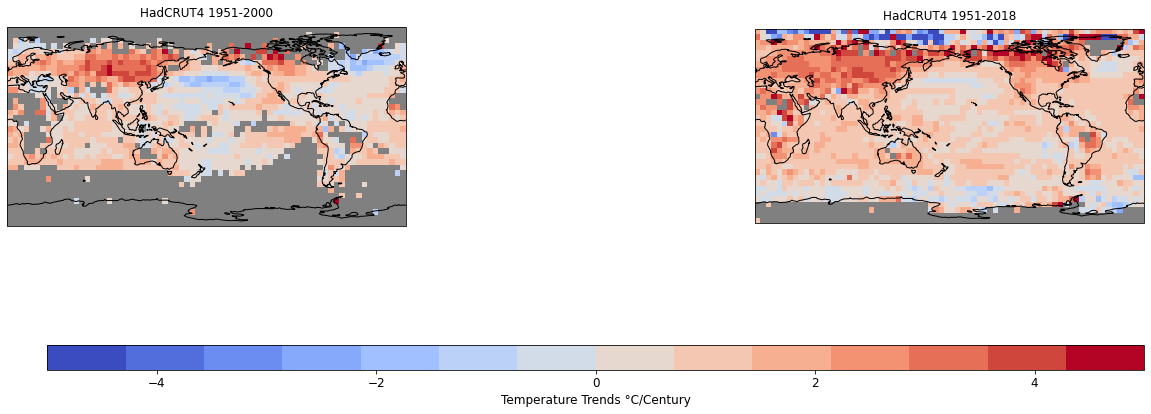

In [10]:


## create mask based on criteria 

hadcrut_med=xr.open_mfdataset('data/HadCRUT.4.6.0.0.median.nc').sel(time=slice('1951-01-01', '2019-01-01'))
mask_1951=create_mask(hadcrut_med.temperature_anomaly.values)


##Example plots of trends
n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
lons=hadcrut_med.longitude.values
lats=hadcrut_med.latitude.values

i=0
for ref in [1951]:
    
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=180))

    i_y+=1
    i+=1
    
    y_ma = np.zeros(mask_1951.shape)
    y_ma = ma.masked_array(y_ma, mask=mask_1951==False)
    y_ma[mask_1951]=trend_hadcrut_med[2000][mask_1951]

    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, y_ma, transform=ccrs.PlateCarree(central_longitude=180), cmap=plt.cm.get_cmap('coolwarm',14),vmin=-5,vmax=5,rasterized=True)
    ax.set_title("HadCRUT4 %i-2000"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=180))
    i_y+=1
    
    i+=1
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, trend_hadcrut_med[2018], transform=ccrs.PlateCarree(central_longitude=180), cmap=plt.cm.get_cmap('coolwarm',14),vmin=-5,vmax=5,rasterized=True)
    ax.set_title("HadCRUT4 %i-2018"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('Temperature Trends °C/Century')  
plt.axis('off')   


Text(0.5, 1.0, '2.5 degree grid cells')

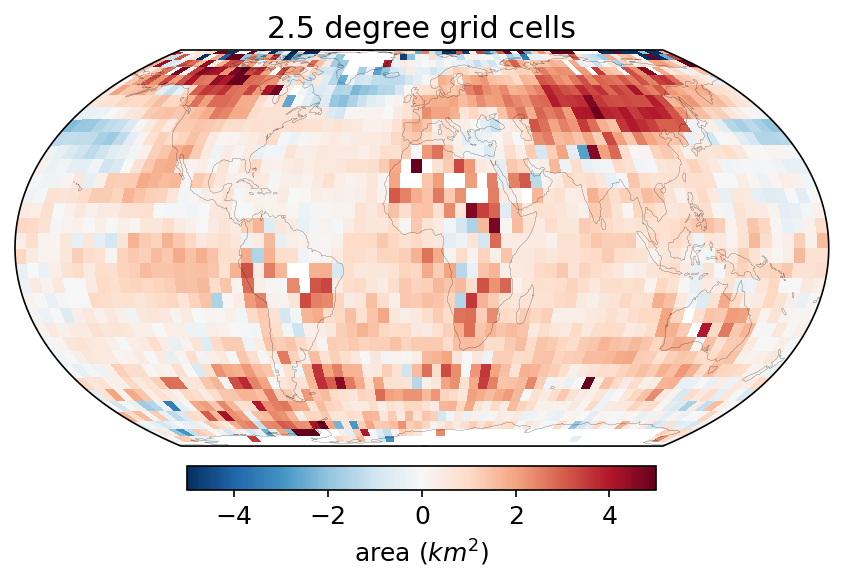

In [70]:
from cartopy import crs as ccrs
import cartopy
import numpy as np


fig = plt.figure(dpi=150, figsize=(7,4.5))

ax = plt.subplot(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

n = np.array(grid_df.temp).reshape(len(grid_df.LAT.unique()),len(grid_df.LON.unique()))

mesh = ax.pcolormesh(
    grid_df.LON.unique(),
    grid_df.LAT.unique(),
    n,
    alpha=1,
    transform=ccrs.PlateCarree(),
    norm = mpl.colors.Normalize(vmin=-5,vmax=5),
    cmap="RdBu_r"
)

cbar = plt.colorbar(mesh, orientation="horizontal",
                   fraction=0.046, pad=0.04)
cbar.set_label('area ($km^2$)')

ax.set_title('2.5 degree grid cells')